created on 11/25/15 (last day at clarapath; just had dinner w momo and dodo)

data source: https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors

In [96]:
import pandas as pd
import gensim
import numpy as np
from sklearn.manifold import TSNE # works better than the tsne package

# step 1: data preparation

In [2]:
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

In [3]:
# each review is split into a list of tokens; text is a list of lists

text = unlabeled_train['review'].map(lambda x: x.lower().split())
len(text)

50000

# step 2: train word2vec model

In [4]:
print "training..."

# ~1 min to train
# min count is minimum frequency of words in order to be relevant
# size is the size of feature vector, usually between 50 and 300
# workers = number of cores

import time

start = time.time() # Start time

model = gensim.models.Word2Vec(text, size=100, window=5, min_count=10, workers=4)

end = time.time()
elapsed = end - start

print 'execution time: ', elapsed

training...
execution time:  48.897685051


In [5]:
# persist trained word2vec model

model.save('word2vec_bagofpopcorn_112515.pkl')

In [30]:
# inspect word similarities

model.most_similar('man')

[('woman', 0.8108645677566528),
 ('girl', 0.7665234804153442),
 ('man,', 0.7512650489807129),
 ('guy', 0.7348310947418213),
 ('soldier', 0.7087733745574951),
 ('boy', 0.6984727382659912),
 ('lady', 0.6977645754814148),
 ('lad', 0.6935749650001526),
 ('kid', 0.6687204241752625),
 ('person', 0.6583636999130249)]

In [44]:
# similiarity is cosine - lets verify
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(man, boy)

array([[ 0.69847274]], dtype=float32)

In [7]:
# size of model's vocabulary is 44k

len(model.syn0)

43962

In [8]:
# each word in the vocabulary has 100 dimensions

model.syn0[0].shape

(100,)

### analogies!

reference: http://arxiv.org/pdf/1301.3781v3.pdf

In [58]:
man = model['man']
boy = model['boy']
girl = model['girl']

In [59]:
unknown = man - boy + girl

In [93]:
woman = model['woman']

In [94]:
cosine_similarity(unknown, woman)

array([[ 0.8395465]], dtype=float32)

# step 3: generate word representations

In [9]:
words_class0 = ['plane', 'ship', 'boat', 'bus', 'truck', 'bridge', 'car', 'helicopter',
               'spaceship', 'train', 'flight', 'ferry']

In [10]:
words_class1 = ['aliens', 'robots', 'zombies', 'spiders', 'vampires', 'mummies', 'gangsters',
                'bees', 'monsters', 'wasps', 'creatures', 'predators', 'animals', 'poachers']

In [11]:
words = words_class0 + words_class1

In [12]:
y = [0] * len(words_class0) + [1] * len(words_class1)

In [13]:
# create a dataframe where rows = words; columns = concepts

x_df = []

for word in words:
    x_df.append(model[word])
    
x_df = pd.DataFrame(np.vstack(x_df))

# step 4: visualize word representations

In [14]:
x = TSNE(n_components=2, perplexity=40, learning_rate=100, verbose=1).fit_transform(x_df)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Error after 67 iterations with early exaggeration: 8.014977
[t-SNE] Error after 279 iterations: 0.492153


/Users/vincenttang/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


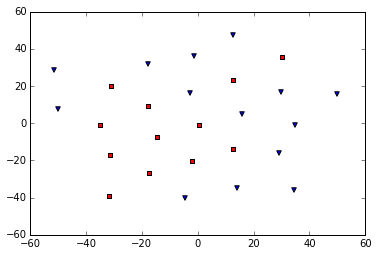

In [15]:
import matplotlib.pyplot as plt
% matplotlib inline

split_pt = len(words_class0) # split points in order to better visualize data

plt.scatter(x[:split_pt, 0], x[:split_pt, 1], c = 'r', marker = 's')
plt.scatter(x[split_pt:, 0], x[split_pt:, 1], c = 'b', marker = 'v')

# step 5: generate clusters

lets create clusters of semantically related words that share the same concept.

this is effectively LDA analysis. in LDA, you return a bunch of topics, each represented by a high dimensional vector of words. in word2vec, you return a bunch of words, each represented by a high dimensional vector of topics. so, LDA is the same as word2vec!

by clustering into semantically related clusters, you are transforming word2vec to LDA.

In [16]:
from sklearn.cluster import KMeans

In [17]:
num_clusters = 5000

kmeans = KMeans(n_clusters = num_clusters)

In [18]:
# fit kmeans on 5k out of 44k

training_data = model.syn0[:5000]

In [19]:
kmeans.fit(training_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5000,
    n_init=10, n_jobs=1, precompute_distances='auto', random_state=None,
    tol=0.0001, verbose=0)

In [20]:
# instantiate dict where k = centroid label and v = list of similar words

clusters_dict = {}

for i in range(0, num_clusters):
    clusters_dict[i] = []

In [21]:
# for each word in the vocabulary
for i, w in enumerate(model.syn0):
    
    # assign word vector to a cluster
    k = kmeans.predict(w)[0]
    
    # find corresponding word to the word vector
    word = model.index2word[i] # index2word is a gensim method
    
    # then add corresponding word to the dictionary where k = centroid label and v = list of words
    clusters_dict[k].append(word)

In [29]:
# inspect clusters of concepts!

for idx in range(50, 60):
    print idx, clusters_dict[idx]

50 ['u']
51 ['twenty']
52 ['7']
53 ['disaster']
54 ['have.', '"how', 'dismiss', 'imagine.']
55 ['spending']
56 ['instance,']
57 ['describes', 'relates', 'dominates']
58 ['teeth', 'brains', 'ears', 'jaw', 'scratching', 'mates', 'toes']
59 ['budget,']
